# Project Checkpoint 1: Dataset Comparison, Selection, and EDA

**Domain:** Fashion & E-commerce  
**Objective:** Compare three candidate datasets, select one for deep EDA (Synerise RecSys 2025), and document findings with decision logs and professional code (PEP 8, vectorized operations).

## Setup

**Decision log:** Using `pandas` for compatibility with Colab and readability; for very large event tables we load only the event types needed for EDA to keep memory manageable. Project root is set so that `amazon_dataset/`, `challenge_dataset/`, and `h_m_dataset/` resolve (e.g., after uploading the project or mounting Drive in Colab).

**Dataset investigation:** List files and approximate sizes for the three dataset directories (run this to verify paths and fill in the comparative analysis).

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "challenge_dataset").exists() and (PROJECT_ROOT.parent / "676_Project").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent / "676_Project"
elif not (PROJECT_ROOT / "challenge_dataset").exists():
    PROJECT_ROOT = Path("/content/676_Project")  # default Colab

CHALLENGE_DIR = PROJECT_ROOT / "challenge_dataset"
HM_DIR = PROJECT_ROOT / "h_m_dataset"
AMAZON_DIR = PROJECT_ROOT / "amazon_dataset"

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
def list_dataset_files(root: Path, label: str) -> None:
    if not root.exists():
        print(f"{label}: path not found: {root}")
        return
    for f in sorted(root.rglob("*"))[:50]:
        rel = f.relative_to(root)
        size = f.stat().st_size / (1024 * 1024) if f.is_file() else None
        print(f"  {rel}" + (f"  ({size:.1f} MB)" if size is not None else ""))

print("challenge_dataset (Synerise):")
list_dataset_files(CHALLENGE_DIR, "Synerise")
print("\nh_m_dataset (H&M):")
list_dataset_files(HM_DIR, "H&M")
print("\namazon_dataset (Amazon Fashion):")
list_dataset_files(AMAZON_DIR, "Amazon")

challenge_dataset (Synerise):
  input
  input/add_to_cart.parquet  (65.7 MB)
  input/page_visit.parquet  (1131.0 MB)
  input/product_buy.parquet  (21.5 MB)
  input/relevant_clients.npy  (7.6 MB)
  input/remove_from_cart.parquet  (24.1 MB)
  input/search_query.parquet  (295.6 MB)
  product_properties.parquet  (53.9 MB)
  target
  target/active_clients.npy  (5.7 MB)
  target/popularity_propensity_category.npy  (0.0 MB)
  target/popularity_propensity_new_sku.npy  (0.0 MB)
  target/popularity_propensity_price.npy  (0.0 MB)
  target/popularity_propensity_sku.npy  (0.0 MB)
  target/propensity_category.npy  (0.0 MB)
  target/propensity_new_sku.npy  (0.0 MB)
  target/propensity_price.npy  (0.0 MB)
  target/propensity_sku.npy  (0.0 MB)
  target/train_target.parquet  (11.0 MB)
  target/validation_target.parquet  (12.7 MB)

h_m_dataset (H&M):
  articles.csv  (34.5 MB)
  customers.csv  (197.5 MB)
  transactions_train.csv  (1154.0 MB)

amazon_dataset (Amazon Fashion):
  Amazon_Fashion.jsonl  (1002.

On my honor, I declare the following resources:
1. No collaborators
2. Amazon Fashion Dataset- https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main
   H&M Personalized Fashion Recommendation dataset - https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
   Synerise Product Purchase Dataset - https://recsys.synerise.com/summary
3. I used Gemini to figure out how to import the files correctly

## Comparative Analysis

Below: per-dataset summary and a single comparison table across supported tasks, data quality, algorithmic feasibility, and bias/ethics. 

**Final Dataset selection:** Synerise RecSys 2025 is chosen for my EDA because it provides rich event types (page_visit → add_to_cart → product_buy) and temporal structure aligned with course topics (e.g., stream mining, graph mining).

### Per-dataset summary

| Dataset | Name & source | Course alignment | Beyond-course | Size & structure | Data types | Target(s) | Licensing |
|--------|----------------|------------------|---------------|------------------|------------|----------|------------|
| **Synerise** | RecSys Challenge 2025 by Synerise; [recsys.synerise.com](https://recsys.synerise.com/data-set) | Weeks 2 (itemsets), 3–4 (bipartite graph), 9 (anomaly), 11 (LSH), 12 (stream) | Sequential pattern mining, neural recommenders, propensity/churn | ~169M events across 5 parquet files; product_properties.parquet | client_id, timestamp, sku/url/query; event-specific columns | Churn, category/product propensity (implicit from events) | Challenge terms |
| **H&M** | H&M Personalized Fashion Recommendations; Kaggle | Weeks 2 (basket/itemsets), 3–4 (user–item graph), 9 (anomaly), 11 (LSH) | Sequential, neural recommenders |  100k rows of transactions + articles + customers CSVs | customer_id, article_id, t_dat; article/customer attributes | Purchase (transaction) | Kaggle competition rules |
| **Amazon Fashion** | Amazon Fashion Product Reviews / HuggingFace | Weeks 2 (co-purchase itemsets), 9 (review outliers), 11 (LSH for similarity) | Sentiment, neural recommenders | 2.0 M Reviews + optional metadata | user_id, item_id, rating, timestamp, review text | Rating, helpfulness | Research / CC-style (varies by subset) |

### Dataset selection and justification

**Selected dataset:** Synerise RecSys 2025 (event logs: page_visit, add_to_cart, remove_from_cart, product_buy, search_query).

**Reasons:**
- Directly supports **frequent itemsets and association rules** (Week 2) via basket-style events and user–item co-occurrence.
- Fits **bipartite graph** and **graph mining** (Weeks 3–4) with clear client–item interactions.
- Enables **anomaly detection** (Week 9) on outlier users or bursty behavior.
- Aligns with **LSH** (Week 11) for scalable similarity over large user/item sets.
- Supports **stream mining** (Week 12) via high-volume temporal event streams and bursty patterns.
- Supports **sequential pattern mining** and propensity/churn modeling beyond the course (e.g., page_visit → add_to_cart → product_buy).
- Rich funnel structure allows meaningful comparison of unordered baskets vs. temporal sequences.

**Trade-offs:**
- No natural text component (unlike Amazon Fashion reviews).
- Labels are implicit (propensity/churn targets provided separately); fewer ready-made supervised tasks than a ratings dataset.
- Full event set is large; EDA and modeling require sampling or chunked processing for typical hardware.

### Comparison table (supported tasks, data quality, feasibility, bias & ethics)

| Dimension | Synerise RecSys 2025 | H&M Personalized Recommendations | Amazon Fashion Reviews |
|-----------|----------------------|-----------------------------------|------------------------|
| **Supported tasks (course)** | Itemsets (baskets), bipartite graph, anomaly (outlier users), LSH (scale similarity), stream (temporal bursts) | Itemsets (transactions), bipartite graph, anomaly, LSH | Itemsets (co-purchase), anomaly (review outliers), LSH (review/item similarity) |
| **Supported tasks (beyond)** | Sequential patterns, neural UBP, propensity/churn | Sequential, neural recommenders | Sentiment, neural recommenders |
| **Data quality** | High volume; sparse user–item; some missingness in optional joins; event types well defined | Dense transactions; clean IDs; possible cold start | Sparsity in user–item; noise in text; missing ratings in some subsets |
| **Algorithmic feasibility** | Scalable with chunking/parquet; memory for full event set large; fits FP-Growth, graph, LSH, streaming | Moderate size; fits in memory; good for Apriori/FP-Growth, graph, LSH | Scale depends on subset; LSH and sampling help; fits itemset and anomaly |
| **Bias & ethics** | Filter bubbles, sustainability (recommendation impact); anonymized | Fashion consumption, representation; Kaggle rules | Review bias, representation; license depends on source |

On my honor, I declare the following resources:
1. No collaborators
2. Amazon Fashion Dataset- https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main
   H&M Personalized Fashion Recommendation dataset - https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
   Synerise Product Purchase Dataset - https://recsys.synerise.com/summary
3. I wrote down many observations about each dataset, and asked Gemini which of the supported tasks beyond and within the course would fit each dataset. From there, I wrote down all of my findings that you see in the above table, Gemini the document of all my findings, and asked it to put it into a table in markdown.

## Exploratory Data Analysis on Selected Dataset(Synerise)

EDA will be performed on the Synerise dataset under `challenge_dataset/`. Event files are parquet: `product_buy.parquet`, `add_to_cart.parquet`, `remove_from_cart.parquet`, `page_visit.parquet`, `search_query.parquet`. We load only the event types needed for funnel and sparsity to control memory.

### Data loading

We use pandas with parquet for compatibility. The full event set (~1.5 GB on disk, ~169M rows) would exceed RAM and crash the kernel, so we stream each parquet in batches (PyArrow `iter_batches`) and keep a 10% random sample per file. This yields a representative subset for EDA (funnel, sparsity, temporal, Zipf) while staying within memory.

In [ ]:
import pyarrow.parquet as pq

def load_synerise_events(base_dir: Path, sample_frac: float = 0.1, batch_size: int = 500_000):
    """Load Synerise event parquet files in chunks and return a sampled combined DataFrame.

    Avoids OOM by streaming each file in batches and keeping only sample_frac of rows.
    """
    base_dir = Path(base_dir)
    event_files = {
        "product_buy": "product_buy.parquet",
        "add_to_cart": "add_to_cart.parquet",
        "remove_from_cart": "remove_from_cart.parquet",
        "page_visit": "page_visit.parquet",
        "search_query": "search_query.parquet",
    }
    parts = []
    for event_type, fname in event_files.items():
        path = base_dir / fname
        if not path.exists():
            path = base_dir / "input" / fname
        if not path.exists():
            continue
        # Stream in batches to avoid loading full file into memory
        reader = pq.ParquetFile(path)
        batch_parts = []
        for batch in reader.iter_batches(batch_size=batch_size):
            df_batch = batch.to_pandas()
            if sample_frac < 1.0:
                df_batch = df_batch.sample(frac=sample_frac, random_state=42)
            if len(df_batch) == 0:
                continue
            df_batch["event_type"] = event_type
            if "sku" not in df_batch.columns and "url" in df_batch.columns:
                df_batch = df_batch.rename(columns={"url": "sku"})
            batch_parts.append(df_batch)
        if batch_parts:
            parts.append(pd.concat(batch_parts, ignore_index=True))
    if not parts:
        raise FileNotFoundError(f"No Synerise parquet files found under {base_dir}")
    return pd.concat(parts, ignore_index=True)

# sample_frac=0.1 keeps ~10% of rows to stay within memory; increase if you have ample RAM
events = load_synerise_events(CHALLENGE_DIR, sample_frac=0.1)
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
events = events.dropna(subset=["timestamp"])
print(events.shape)
print(events["event_type"].value_counts())

(17563746, 5)
event_type
page_visit          15603201
search_query         1021883
add_to_cart           567406
remove_from_cart      193717
product_buy           177539
Name: count, dtype: int64


1. No collaborators
2. No web pages consulted
3. I asked Gemini how to load the data files quicker, since I was sometimes getting issues with my Python kernel running out of memory. It suggested that I sample the dataset to get this info, and it modified my initial code to do so.

### Sparsity check

 We define the user–item matrix from events that have both `client_id` and `sku` (product_buy, add_to_cart, remove_from_cart). We aggregate to binary interaction (at least one event per user–item pair). Density = non-zero entries / (n_users × n_items); we report it to assess feasibility for matrix-based and LSH methods.

In [5]:
# Restrict to events with user-item (client_id, sku)
ui_events = events.loc[events["event_type"].isin(["product_buy", "add_to_cart", "remove_from_cart"])].copy()
ui_events = ui_events.dropna(subset=["client_id", "sku"])

n_interactions = len(ui_events)
n_users = ui_events["client_id"].nunique()
n_items = ui_events["sku"].nunique()
n_pairs = ui_events.groupby(["client_id", "sku"]).size()
n_unique_pairs = len(n_pairs)

density = n_unique_pairs / (n_users * n_items) if (n_users * n_items) > 0 else 0.0
print(f"User–item pairs (at least one event): {n_unique_pairs:,}")
print(f"Users: {n_users:,}, Items: {n_items:,}")
print(f"Interaction density: {density:.6e}")

User–item pairs (at least one event): 851,233
Users: 549,247, Items: 385,744
Interaction density: 4.017738e-06


1. No collaborators
2. NO web pages consulted
3. I asked Gemini how to measure sparsity of the dataset, and it recommended I calculate the number of pairs w.r.t to the dimensions.

### Funnel visualization

The funnel is page_visit → add_to_cart → product_buy. We count unique clients who performed each step (at least one event of that type). Drop-off is implied by the decrease between stages. We use a bar plot of counts for clarity.

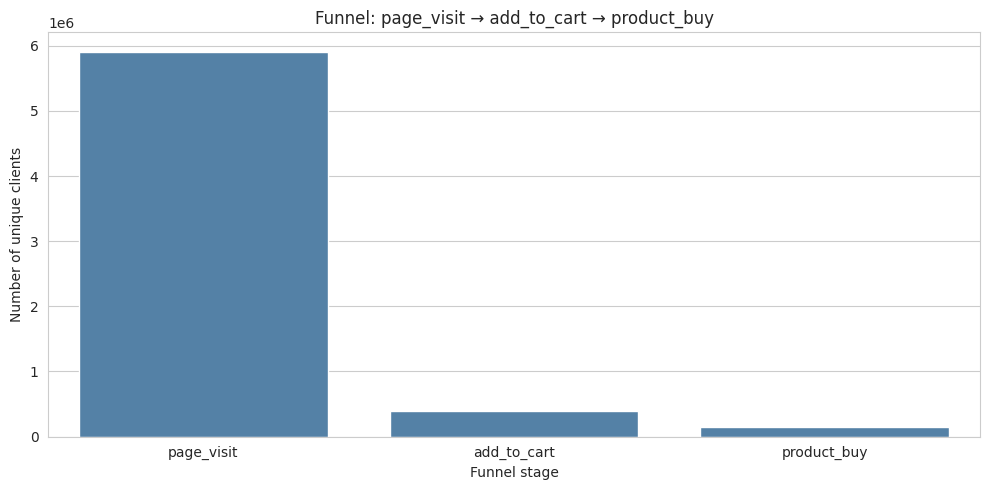

In [6]:
visit_clients = set(events.loc[events["event_type"] == "page_visit", "client_id"].dropna().unique())
cart_clients = set(events.loc[events["event_type"] == "add_to_cart", "client_id"].dropna().unique())
buy_clients = set(events.loc[events["event_type"] == "product_buy", "client_id"].dropna().unique())

funnel_counts = pd.DataFrame({
    "stage": ["page_visit", "add_to_cart", "product_buy"],
    "n_clients": [len(visit_clients), len(cart_clients), len(buy_clients)],
})

fig, ax = plt.subplots()
sns.barplot(data=funnel_counts, x="stage", y="n_clients", order=funnel_counts["stage"], color="steelblue")
ax.set_ylabel("Number of unique clients")
ax.set_xlabel("Funnel stage")
ax.set_title("Funnel: page_visit → add_to_cart → product_buy")
plt.tight_layout()
plt.show()

1. No collaborators
2. No web pages
3. I used Gemini to graph the data and it recommended I put the funnel_counts into a dataframe.

### Temporal analysis

We plot event counts by day to identify bursty periods suitable for Stream Mining (Week 12). Daily granularity is a reasonable trade-off between noise and trend, we could measure hourly reports for finer burst detection.

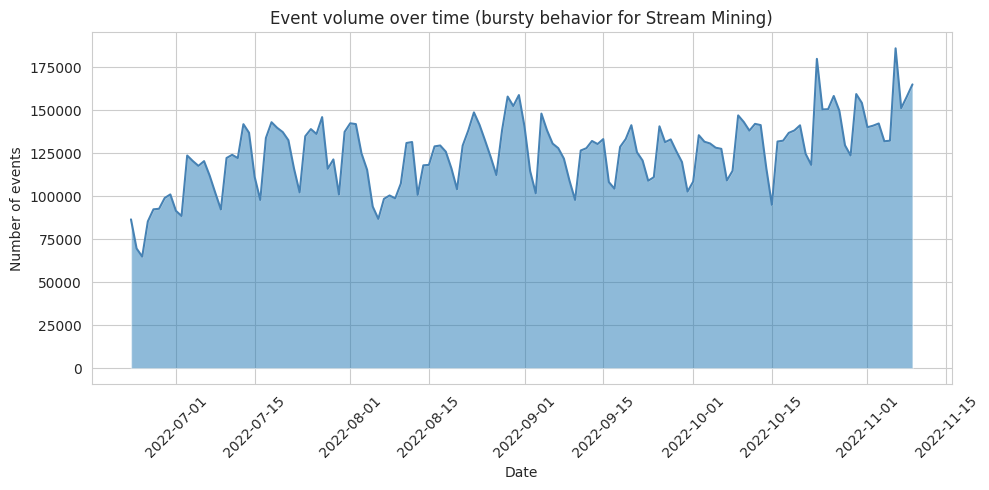

In [7]:
events["date"] = events["timestamp"].dt.date
daily = events.groupby("date", as_index=False).size()
daily["date"] = pd.to_datetime(daily["date"])

fig, ax = plt.subplots()
ax.fill_between(daily["date"], daily["size"], alpha=0.5)
ax.plot(daily["date"], daily["size"], color="steelblue")
ax.set_ylabel("Number of events")
ax.set_xlabel("Date")
ax.set_title("Event volume over time (bursty behavior for Stream Mining)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. No collaborators
2. No web pages
3. Gemini actually recommended that I do this analysis, so I asked it how to do so and it gave me step by step instructions on what data we needed, and I extracted the fields myself. I then had it graph the data for me.

### Zipf's law (long tail)

Item frequency is power-law distributed; a log-log plot of rank vs. frequency reveals the long tail. We define "item" as `sku` and count events per sku (from product_buy, add_to_cart, remove_from_cart), then rank by frequency and plot rank vs. frequency on log scales.

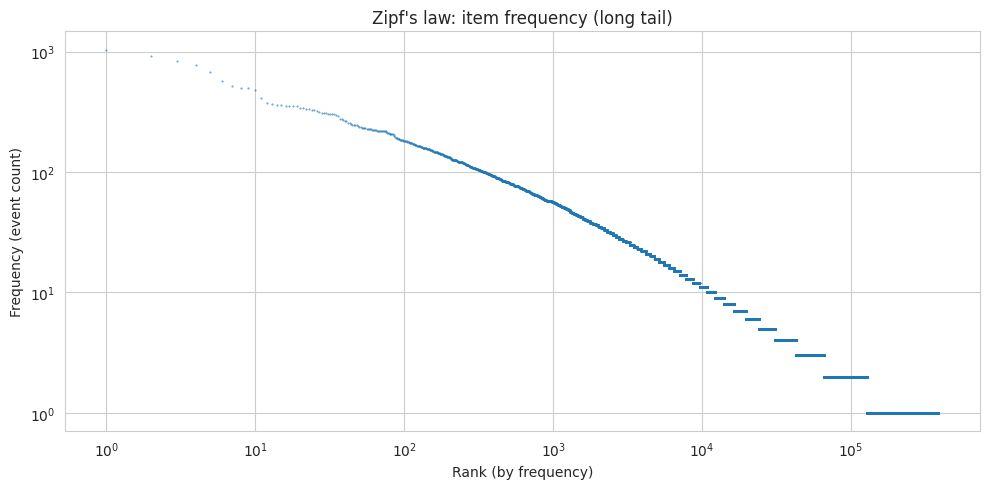

In [8]:
item_counts = ui_events.groupby("sku", as_index=False).size()
item_counts = item_counts.sort_values("size", ascending=False).reset_index(drop=True)
item_counts["rank"] = np.arange(1, len(item_counts) + 1)

fig, ax = plt.subplots()
ax.loglog(item_counts["rank"], item_counts["size"], ".", markersize=1, alpha=0.7)
ax.set_xlabel("Rank (by frequency)")
ax.set_ylabel("Frequency (event count)")
ax.set_title("Zipf's law: item frequency (long tail)")
plt.tight_layout()
plt.show()

1. No collaborators
2. NO web pages
3. I actually learned about Zipfs law in a talk given by Dr. Samson Zhou on Tuesday, and I figured it may play a role here. I asked Gemini how can I examine its behavior in this dataset, and I took its suggestions and wrote the code to get the item counts, and had it generate a graph.

## Insights and Research Questions

Three research questions that bridge course topics with beyond-course techniques:

1. **LSH and k-NN latency (Week 11):** Can Locality-Sensitive Hashing improve the latency of a k-NN style recommender on the Synerise user–item graph without sacrificing 2025-standard accuracy (e.g., propensity or churn)?

2. **Stream mining and bursty behavior (Week 12):** Can stream mining techniques (e.g., decay or sliding windows) on the temporal distribution of page_visit and product_buy events improve real-time propensity or churn signals compared to batch-only models?

3. **Bipartite graph and beyond-course sequential patterns (Weeks 3–4):** Can combining bipartite user–item graph structure (PageRank or similar) with sequential pattern mining over the funnel (page_visit → add_to_cart → product_buy) improve next-item or category propensity over graph-only or sequence-only baselines?

1. No collaborators
2. No external web pages
3. I consulted Gemini for how do the future course topics possibly bring out beyond-couse techniques. I then used this information to do the analysis above.